In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import TextDocPreprocessor2
doc_preprocessor = TextDocPreprocessor2('data2')

In [3]:
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser


n_docs=5

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)

Clearing existing...
Running UDF...
[========                                ] 20%data2/doc7
[========                                ] 20%data2/doc40
[================                        ] 40%data2/doc116
[========================                ] 60%data2/doc137
[================================        ] 80%data2/doc19
[========================================] 100%data2/doc20
[================================================] 120%data2/doc71
data2/doc14
data2/doc95
data2/doc59
data2/doc58
data2/doc3
data2/doc141
data2/doc56
data2/doc104
data2/doc13
data2/doc72
data2/doc129
data2/doc9
data2/doc78
data2/doc106
data2/doc93
data2/doc131
data2/doc51
data2/doc8
data2/doc94
data2/doc47
data2/doc23
data2/doc144
data2/doc67
data2/doc74
data2/doc44
data2/doc70
data2/doc64
data2/doc133
data2/doc124
data2/doc118
data2/doc111
data2/doc100
data2/doc82
data2/doc114
data2/doc123
data2/doc69
data2/doc4
data2/doc103
data2/doc12
data2/doc80
data2/doc149
data2/doc21
data2/doc61
data2/doc79
data2/do

In [4]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())


('Documents:', 151)
('Sentences:', 1609)


In [5]:
from snorkel.models import candidate_subclass

Disaster = candidate_subclass('Disaster', ['Date','Location'])

In [6]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import DateMatcher, LocationMatcher
ngrams         = Ngrams(n_max=7)
#person_matcher = PersonMatcher(longest_match_only=True)
location_matcher = LocationMatcher(longest_match_only=True)
date_matcher = DateMatcher(longest_match_only=True)
#dict=['earthquake','flood','cyclone','fire']
#dictionary_matcher=DictionaryMatch(d=dict)
cand_extractor = CandidateExtractor(Disaster, [ngrams, ngrams], [date_matcher, location_matcher])

In [7]:
from snorkel.models import Document
#from util import number_of_people


docs = session.query(Document)

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 3 == 2:
            dev_sents.add(s)
        elif i % 3 == 1:
            dev_sents.add(s)
        else:
            dev_sents.add(s)

In [9]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Disaster).filter(Disaster.split == i).count())



Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 0)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 89)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 0)
CPU times: user 12.4 s, sys: 600 ms, total: 13 s
Wall time: 12.6 s


In [17]:
import re
from snorkel.lf_helpers import (
    get_between_tokens,
    get_text_between, get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

                   
meteorological_disasters = { 'storm', 'bizzard', 'tornado', 'hurricane', 'cyclone', 'avalanches', 'heatwave','coldwave' 'drought', 'hailstorm'}
hydrological_disasters = { 'flood' , 'tsunami', 'limnic eruption' , 'famine' , 'forest fire' }

geological_disasters = { 'earthquake', 'volcano' , 'rock fall'}

                   
biological_disasters = { 'epidemic', 'pandemic' , 'influenza'}

manmade_disasters = { 'blast', 'bomb explosion', 'bomb blast', 'bomb', 'bombings', 'surgical strike', 'shooting', 'firing', 'gun fire' , 'riots' , 'armed conflict'}

def LF_mdisaster(c):
     return 1 if len(meteorological_disasters.intersection(get_between_tokens(c))) > 0 else 0

def LF_hdisaster(c):
    return 1 if len(hydrological_disasters.intersection(get_between_tokens(c))) > 0 else 0

def LF_gdisaster(c):
    return 1 if len(geological_disasters.intersection(get_between_tokens(c))) > 0 else 0

def LF_bdisaster(c):
    return 1 if len(biological_disasters.intersection(get_between_tokens(c))) > 0 else 0

def LF_mandisaster(c):
    return 1 if len(manmade_disasters.intersection(get_between_tokens(c))) > 0 else 0
def LF_tdisaster(c):
      return 1 if 'train’' in get_between_tokens(c) and 'collided’' in get_right_tokens(c) else 0
def LF_killed(c):
    return 1 if re.search (r'{{A}}+\w+\s+killed+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I)  else 0

def LF_injured(c):
    return 1 if re.search (r'{{A}}+\w+\s+injured+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I)  else 0

def LF_dead(c):
    return 1 if re.search (r'{{A}}+\w+\s+dead+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_damage(c):
    return 1 if re.search (r'{{A}}+\w+\s+heavy+\s+damage+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_conflict(c):
    return 1 if re.search (r'{{A}}+\w+\s+conflict+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0


def ltp(x):
    return '(' + '|'.join(x) + ')'

trigger1 = ['killed', 'kills', 'killing']

def LF_kill(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger1) + '.\w', 1)
trigger2 = ['violence', 'violent', 'rioting']
def LF_violence(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger2) + '.\w', 1)
trigger3 = ['crashed’,’collided’,’hit’']

def LF_crash(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger3) + '.\w', 1)

trigger4 = ['surgical strike', 'strike', 'struck', 'hit the target']

def LF_strike(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger4) + '.\w', 1)

trigger5 = ['cold', 'heat']

def LF_wave(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger4) +"wave"+ '.\w', 1)
def LF_cold(c):
    return 1 if re.search (r'{{A}}+\w+\s+cold+arctic +air+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

trigger6 = ['flood' ,'floods' , 'flooding', 'flooded']
def LF_flood(c):
     return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger4) + '.\w', 1)

trigger7 = ['eruption' ,'erupting' , 'erupted',  'erupt']

def LF_eruption(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger7) + '.\w', 1)

trigger8 = ['fell off' ,'slide', 'fall']

#def LF_rock(c):
    #return rule_regex_search_btw_AB(c, '.\w' + rock + ltp(trigger8) + '.\w', 1)

trigger9 = ['cholera' ,'ebola', 'dengue']

def LF_epidemic(c):
    return rule_regex_search_btw_AB(c, '.\w' + ltp(trigger9) + '.\w', 1)


def LF_tsunami(c):
    return 1 if re.search (r'{{A}}+\w+\s+tsunami+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_confront(c):
    return 1 if re.search (r'{{A}}+\w+\s+armed+confrontation+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_rammed(c):
    return 1 if re.search (r'{{A}}+LF_rammed\w+\s+rammed+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_smashed(c):
    return 1 if re.search (r'{{A}}+\w+\s+smashed+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_exploded(c):
    return 1 if re.search (r'{{A}}+\w+\s+exploded+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_shipwrecked(c):
    return 1 if re.search (r'{{A}}+\w+\s+shipwrecked+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_nuclearmeltdown(c):
    return 1 if re.search (r'{{A}}+\w+\s+nuclear meltdown.+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_tornado(c):
    return 1 if re.search (r'{{A}}+\w+\s+tornado(es)+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_limniceruption(c):
    return 1 if re.search (r'{{A}}+\w+\s+limnic eruption+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

def LF_wildfire(c):
    return 1 if re.search (r'{{A}}+\w+\s+wildfire(es)+\s+\w+{{B}}',  get_tagged_text(c), flags =re.I) else 0

In [18]:
LFs = [
     LF_mdisaster,  LF_gdisaster,  LF_hdisaster,  LF_bdisaster,  LF_mandisaster, LF_tdisaster, LF_wildfire,LF_limniceruption, LF_tornado
,LF_nuclearmeltdown, LF_shipwrecked  ,LF_exploded, LF_smashed, LF_rammed,  LF_confront,LF_tsunami ,LF_epidemic,LF_eruption,LF_flood,
LF_wave,LF_strike, LF_crash, LF_violence, LF_kill, LF_conflict, LF_damage, LF_dead, LF_injured, LF_kill ]
 


In [19]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [20]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

np.random.seed(1701)
%time L_train = labeler.apply(split=1)
L_train

In [22]:
L_train.get_candidate(session, 1)

Disaster(Span("Saturday", sentence=1482, chars=[415,422], words=[83,83]), Span("Kashmir", sentence=1482, chars=[212,218], words=[44,44]))

In [24]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)



In [25]:
gen_model.weights.lf_accuracy

array([ 0.12463982,  0.10858647,  0.1022804 ,  0.06487746,  0.09826932,
        0.0742083 ,  0.07212921,  0.06903546,  0.06165034,  0.06189891,
        0.07902076,  0.04799645,  0.07328307,  0.06931367,  0.06222347,
        0.07885109,  0.05025031,  0.08401689,  0.06746703,  0.07175606,
        0.07967487,  0.06244045,  0.06603633,  0.08153954,  0.08878191,
        0.05491278,  0.07185109,  0.07558461])

In [26]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.565250,0.6682,0.559104,0.377697
1,0.558828,0.6757,0.550673,0.371446
2,0.544047,0.6652,0.539810,0.366405
3,0.529473,0.6735,0.526788,0.354910
4,0.543245,0.6706,0.544300,0.371648
5,0.539112,0.6737,0.533615,0.356927
6,0.548979,0.6707,0.540732,0.369429
7,0.531808,0.6775,0.527885,0.356927
8,0.531017,0.6706,0.528010,0.357330
9,0.534704,0.6714,0.535828,0.372454


In [27]:
train_marginals = gen_model.marginals(L_train)

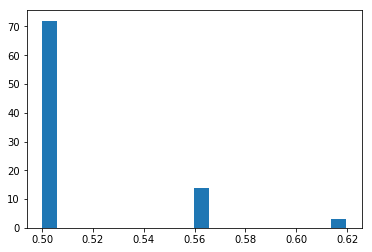

In [35]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

